Customer Segmentation Analysis

## Problem Description
The goal of this project is to divide mall customers into meaningful groups according to demographic and behavioral factors such as age, annual income, spending score and gender. This segmentation would help businesses gain understanding of the present and potential customers and adapt their marketing strategies to target them more effectively. I will using unsupervised machine learning techniques to discover natural patterns in the data to help identify these groups.

## Dataset Overview
The dataset contains 200 entries with the following features:
- Gender: Categorical (Male/Female)
- Age: Numerical (18-70 years)
- Annual Income: Numerical (15k-137k)
- Spending Score: Numerical (1-100)

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import kagglehub
import os
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

path = kagglehub.dataset_download("vjchoudhary7/customer-segmentation-tutorial-in-python")

dataset_path = os.path.join(path, 'Mall_Customers.csv')
data = pd.read_csv(dataset_path)
data = data.drop('CustomerID', axis=1)
print("\nFirst few rows of the dataset:")
print(data.head())
print("\nDataset info:")
print(data.info())

100%|██████████| 1.55k/1.55k [00:00<00:00, 2.88MB/s]

Extracting files...

First few rows of the dataset:
   Gender  Age  Annual Income (k$)  Spending Score (1-100)
0    Male   19                  15                      39
1    Male   21                  15                      81
2  Female   20                  16                       6
3  Female   23                  16                      77
4  Female   31                  17                      40

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Gender                  200 non-null    object
 1   Age                     200 non-null    int64 
 2   Annual Income (k$)      200 non-null    int64 
 3   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 6.4+ KB
None


## Data Processing
Standardizing numerical features and encode categorical ones to prepare for clustering.

In [ ]:
numerical_features = ['Age', 'Annual Income (k$)', 'Spending Score (1-100)']
categorical_features = ['Gender']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(drop='first'), categorical_features)
    ])

processed_data = preprocessor.fit_transform(data)
print("Shape of processed data:", processed_data.shape)
print("\nSample of processed data (first 5 rows):")
print(processed_data[:5])

Shape of processed data: (200, 4)

Sample of processed data (first 5 rows):
[[-1.42456879 -1.73899919 -0.43480148  1.        ]
 [-1.28103541 -1.73899919  1.19570407  1.        ]
 [-1.3528021  -1.70082976 -1.71591298  0.        ]
 [-1.13750203 -1.70082976  1.04041783  0.        ]
 [-0.56336851 -1.66266033 -0.39597992  0.        ]]


### Preprocessing Results
The processed data has a shape of (200, 4), with 3 standardized numerical features and one categorical gender feature. This ensures all features are on the same scale which critical for clustering accuracy.

## Exploratory Data Analysis (EDA)

The EDA helps us understand feature distributions, identify trends, and assess clustering potential before modeling.

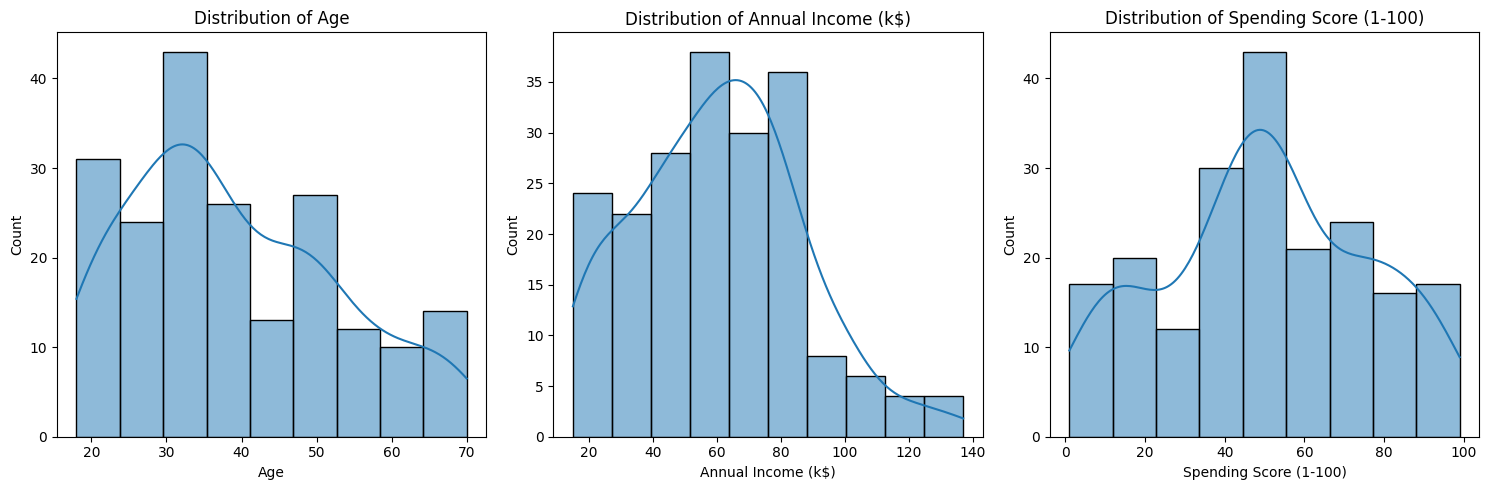

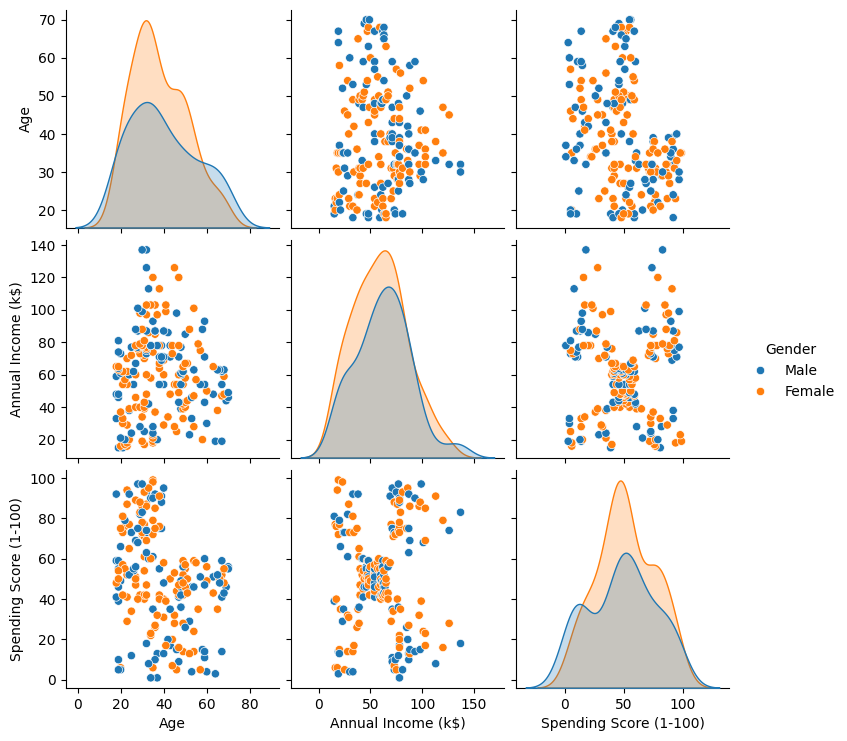

In [ ]:
# Histograms for numerical features
plt.figure(figsize=(15, 5))
for i, col in enumerate(['Age', 'Annual Income (k$)', 'Spending Score (1-100)']):
    plt.subplot(1, 3, i+1)
    sns.histplot(data[col], kde=True)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

# Pair plot for feature relationships
sns.pairplot(data, hue='Gender')
plt.show()

### EDA Findings
- Age: Uniformly distributed, with a slight peak around 30-40 years, indicating a broad age range.
- Annual Income: Right-skewed, with most customers earning 20-80k, and a few high earners up to 137k.
- Spending Score: Average right in the middle, and decreased going down to 0 and up to 100.
- Gender: Pair plots show overlap, indicating gender alone does not drive clustering but contributes to patterns.

These observations suggest clustering could reveal distinct customer profiles.

## Clustering Analysis

### Clustering Methodology
Four clustering algorithms are used to evaluate the data and assign silhouette scores:
- K-Means: Partitions data into 5 clusters.
- Hierarchical: Builds a 5-cluster hierarchy.
- DBSCAN: Identifies density-based clusters.
- GMM: Models 5 probabilistic clusters.

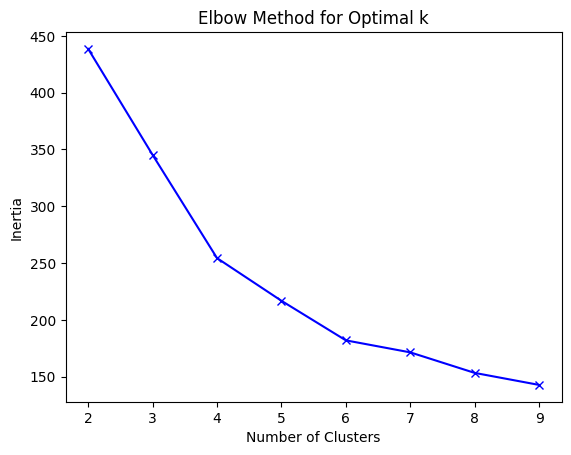

K-Means Silhouette Score: 0.34977050035201074
Hierarchical Clustering Silhouette Score: 0.3477559149875169
DBSCAN number of clusters (excluding noise): 2
DBSCAN Silhouette Score: 0.0998838605060247
GMM Silhouette Score: 0.33231744771690586


In [ ]:
inertia = []
K = range(2, 10)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(processed_data)
    inertia.append(kmeans.inertia_)
plt.plot(K, inertia, 'bx-')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()

kmeans = KMeans(n_clusters=5, random_state=42)
kmeans_labels = kmeans.fit_predict(processed_data)
kmeans_silhouette = silhouette_score(processed_data, kmeans_labels)
print('K-Means Silhouette Score:', kmeans_silhouette)

hierarchical = AgglomerativeClustering(n_clusters=5)
hierarchical_labels = hierarchical.fit_predict(processed_data)
hierarchical_silhouette = silhouette_score(processed_data, hierarchical_labels)
print('Hierarchical Clustering Silhouette Score:', hierarchical_silhouette)

dbscan = DBSCAN(eps=1.0, min_samples=5)
dbscan_labels = dbscan.fit_predict(processed_data)
dbscan_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
print('DBSCAN number of clusters (excluding noise):', dbscan_clusters)
dbscan_silhouette = silhouette_score(processed_data, dbscan_labels) if dbscan_clusters > 1 else -1
print('DBSCAN Silhouette Score:', dbscan_silhouette)

gmm = GaussianMixture(n_components=5, random_state=42)
gmm_labels = gmm.fit_predict(processed_data)
gmm_silhouette = silhouette_score(processed_data, gmm_labels)
print('GMM Silhouette Score:', gmm_silhouette)

### Clustering Evaluation
The elbow plot shows an inflection around 5 clusters, supporting our choice. Silhouette scores are:
- K-Means (0.35): Moderate separation, indicating well-defined clusters.
- Hierarchical (0.35): Close to K-Means, suggesting consistency.
- DBSCAN (2 clusters, 0.10): Lower score, reflecting density-based clustering with fewer, looser groups.
- GMM (0.33): Slightly lower, typical for probabilistic clustering.


## Visualization with PCA

Explained variance by 2 PCA components: 71.77%


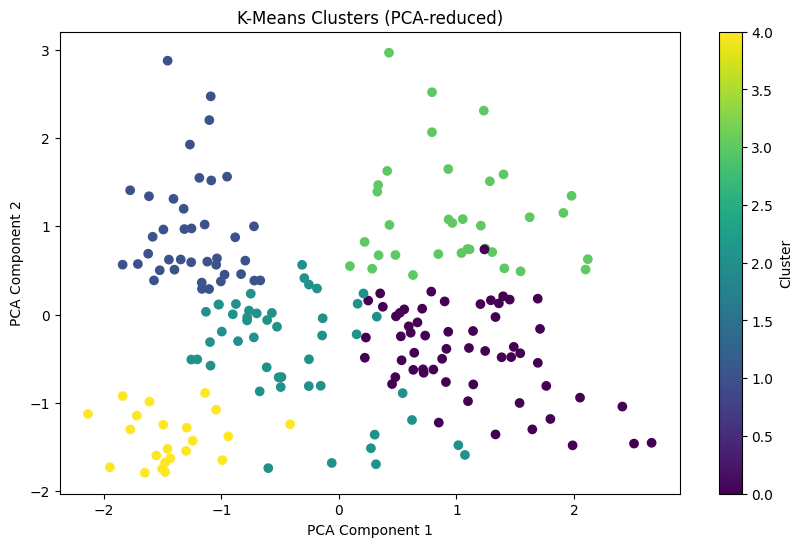

In [ ]:
# PCA transformation
pca = PCA(n_components=2)
pca_data = pca.fit_transform(processed_data)
explained_variance = pca.explained_variance_ratio_.sum()
print(f'Explained variance by 2 PCA components: {explained_variance:.2%}')

# K-Means PCA plot
plt.figure(figsize=(10, 6))
scatter = plt.scatter(pca_data[:, 0], pca_data[:, 1], c=kmeans_labels, cmap='viridis')
plt.title('K-Means Clusters (PCA-reduced)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(scatter, label='Cluster')
plt.show()

### PCA Analysis
The plot explains 71.77% of the variance and there are displaying five K-Means clusters. The clusters are distinct but do have overlap, showing that there are shared traits among groups such as income level and spending.

## Cluster Interpretation


In [ ]:
data['Cluster'] = kmeans_labels

print("Cluster Summaries (K-Means):")
cluster_summary = data.groupby('Cluster')[numerical_features].mean()
print(cluster_summary)

print("\nNumber of customers per cluster:")
print(data['Cluster'].value_counts())

Cluster Summaries (K-Means):
               Age  Annual Income (k$)  Spending Score (1-100)
Cluster                                                       
0        55.551724           48.482759               41.775862
1        32.692308           86.538462               82.128205
2        27.957447           50.000000               44.638298
3        41.264706           88.500000               16.764706
4        25.272727           25.727273               79.363636

Number of customers per cluster:
Cluster
0    58
2    47
1    39
3    34
4    22
Name: count, dtype: int64


### Cluster Profiles
- Cluster 0: Average age 55.6, income 48.5k, spending 41.8 (58 customers)—older, average spenders.
- Cluster 1: Age 32.7, income 86.5k, spending 82.1 (39 customers)—young, affluent spenders.
- Cluster 2: Age 27.9, income 50k, spending 44.6 (47 customers)—young, average spenders.
- Cluster 3: Age 41.3, income 88.5k, spending 16.8 (34 customers)—middle-aged, cautious spenders.
- Cluster 4: Age 25.3, income 25.7k, spending 79.4 (22 customers)—young, irresponsible spenders

## Detailed Visualizations
Using box plots and bar plots to analyze feature distributions.

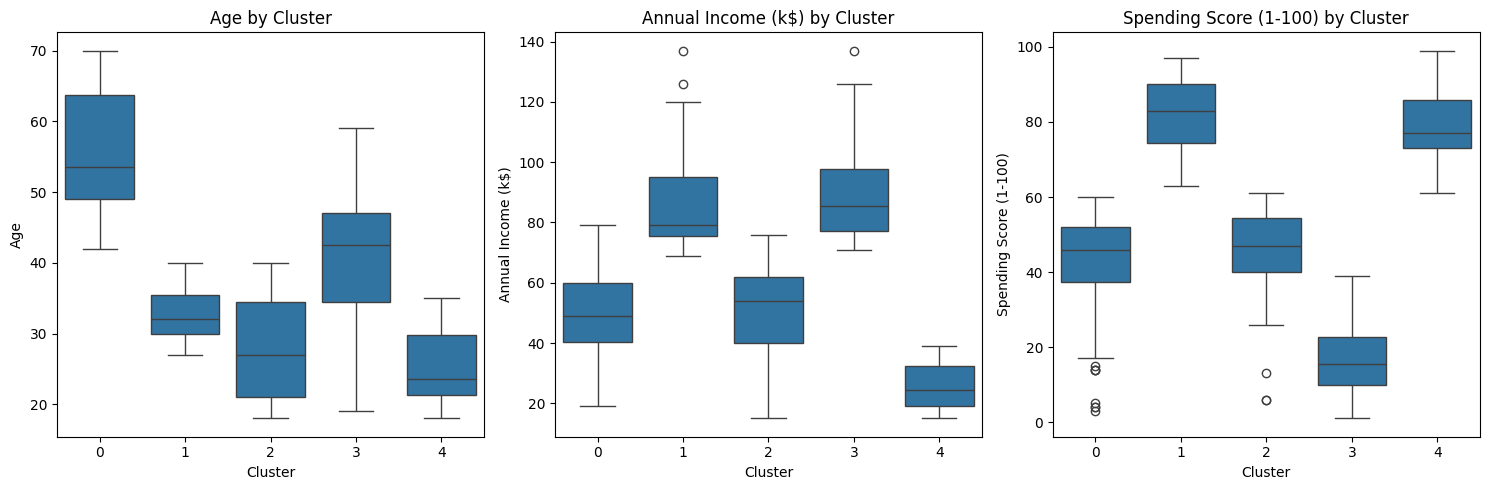

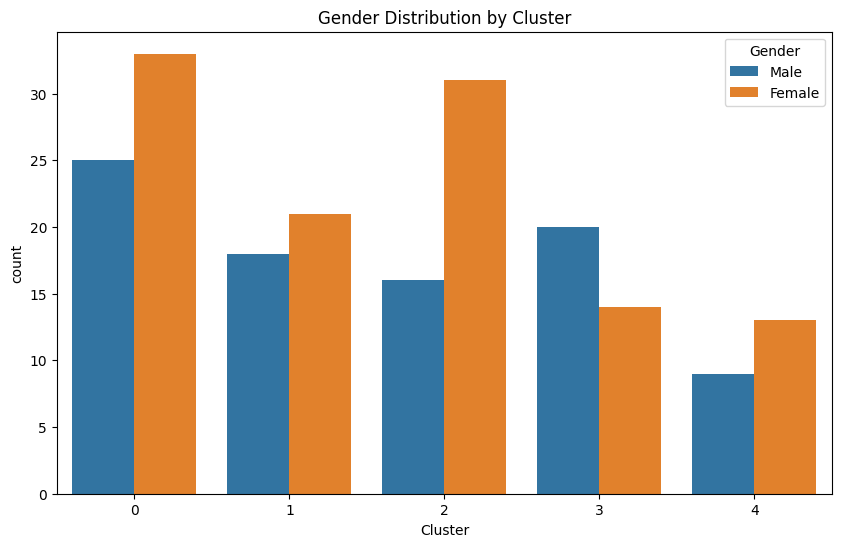

In [ ]:
# Box plots for numerical features
plt.figure(figsize=(15, 5))
for i, col in enumerate(numerical_features):
    plt.subplot(1, 3, i+1)
    sns.boxplot(x='Cluster', y=col, data=data)
    plt.title(f'{col} by Cluster')
plt.tight_layout()
plt.show()

# Gender distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='Cluster', hue='Gender', data=data)
plt.title('Gender Distribution by Cluster')
plt.show()

### Visualization Analysis
- Box Plots: Cluster 2 shows low income (\~25k) but high spending (\~80). Cluster 3 has high income (\~88k) but low spending (\~17). Cluster 0 has a median age around \~50-60, while Clusters 2 and 4 are younger (\~25-30).

## Discussion and Analysis

The analysis identifies five K-Means segments with distinct profiles:
- Cluster 0: Older, balanced spenders (55.6 years, 48.5k income, 41.8 spending).
- Cluster 1: Young, affluent high spenders (32.7 years, 86.5k income, 82.1 spending).
- Cluster 2: Young, average income average spenders (27.9 years, 50k income, 44.6 spending).
- Cluster 3: Middle-aged, affluent average spenders (41.3 years, 88.5k income, 16.8 spending).
- Cluster 4: Young, irresponsible spenders (25.3 years, 25.7k income, 79.4 spending).

The Silhouette scores from earlier show moderate separation, and is validated by the PCA plot’s distinct yet overlapping clusters. DBSCAN’s 2 clusters with a 0.10 silhouette score suggest a broader density-based grouping, likely capturing major trends such as high vs low spending. Box plots highlight income/spending relationships, while gender distributions add demographic context. This multi-method approach shows K-Means as the most interpretable method, with potential for targeted marketing strategies.


### What problem do you solve?
I addressed customer segmentation to help businesses understand and target mall customers based on age, income, spending behavior, and gender, to increase marketing effectiveness.

### What ML approach do you use?
I used unsupervised learning with K-Means, Hierarchical Clustering, DBSCAN, and GMM, supplemented by preprocessing, and PCA for visualization

Dataset

- Choudhary, V. (n.d.). *Customer Segmentation Tutorial in Python*. Kaggle. Retrieved from https://www.kaggle.com/datasets/vjchoudhary7/customer-segmentation-tutorial-in-python